In [1]:
# import pandas as pd
import MagmaPandas as mp
import MagmaPandas.PEC as pec
import pandas as pd
import elements as e
import matplotlib.pyplot as plt
import meltInc.plotting as p

p.layout()
config_pec = pec.PEC_configuration
config = mp.configuration
config.print()


################ MagmaPandas ################
#############################################

General settings____________________________
fO2 buffer................................QFM
ΔQFM........................................1
Melt Fe3+/Fe2+........................borisov
Kd Fe-Mg ol-melt.......................toplis
Melt thermometer...............putirka2008_15
Volatile solubility model......IaconoMarziano
Volatile species........................mixed




In [2]:
melt = mp.read_melt('./melt.csv', index_col=['name'], total_col='total')
olivine = mp.read_olivine('./olivine.csv', index_col=['name'], total_col="total")

In [3]:
samples = ["PI041-04-06", "PI041-02-01", "PI041-02-02"]
inclusions = melt.copy()
ol_host = olivine.copy()
forsterites = ol_host.forsterite
Fo = 0.9
# FeO_initial = lambda x: 11.3981 - 0.07896 * x["MgO"]
FeO_initial = 11.2
P_bar = 1

In [ ]:
equilibrated_inclusions = mp.Melt(index=inclusions.index, columns=inclusions.columns, dtype=float, units="wt. %", datatype="oxide")
ol_equilibrated = pd.Series(index=inclusions.index, dtype=float)
temperatures = pd.Series(index=inclusions.index, dtype=float)
Kds = pd.Series(index=inclusions.index, dtype=float)

totalItems= equilibrated_inclusions.shape[0]
for i, ((idx, mi), (_, ol)) in enumerate(zip(inclusions.iterrows(), ol_host.iterrows())):

    print(f"{i + 1:0>3}/{totalItems:0>3} inclusions equilibrated", end= "\r")
    x, oc, t, kd = pec.Fe_equilibrate(mi, ol, P_bar)
    # print(f"{abs(t['old'] - t['new']):.2f}", end="\n")
    equilibrated_inclusions.loc[idx] = x.iloc[-1]
    ol_equilibrated.loc[idx] = oc[-1] 
    Kds.loc[idx] = kd["Real"]

In [ ]:
corrected_inclusions = mp.Melt(index=inclusions.index, columns=inclusions.columns, dtype=float, units="wt. %", datatype="oxide")
ol_crystallised = pd.Series(index=inclusions.index, dtype=float)

totalItems = equilibrated_inclusions.shape[0]

for i, ((idx, mi), (_, ol)) in enumerate(zip(equilibrated_inclusions.iterrows(), ol_host.iterrows())):

    print(f"{i + 1:0>3}/{totalItems:0>3} inclusions corrected", end= "\r")

    x2, oc2, kd2, t = pec.crystallisation_correction(mi, ol, FeO_initial, P_bar)
    corrected_inclusions.loc[idx] = x2.iloc[-1]
    ol_crystallised.loc[idx] = oc2[-1]

In [ ]:
(ol_crystallised + ol_equilibrated) * 100

In [4]:
mi_pec = pec.PEC_olivine(inclusions, ol_host, P_bar, FeO_initial)

In [ ]:
mi_pec.reset()
X, OC, T = mi_pec.correct()

In [ ]:
OC * 100

In [ ]:
OC * 100

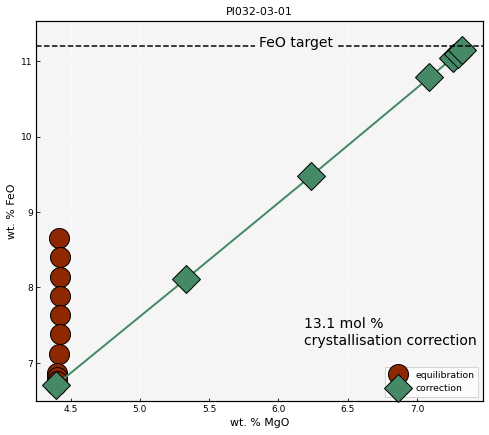

In [5]:
t = mi_pec.correct_inclusion(5)

In [ ]:
import MagmaPandas.geochemistry.fO2 as fO2
import MagmaPandas.geochemistry.Fe_redox as fe

T_K = X.temperature(P_bar)
moles = X.moles
fO2 = fO2.fO2_QFM(1, T_K, P_bar)
Fe3Fe2 = fe.Fe_redox.kressCarmichael(moles, T_K, fO2, P_bar)

Fe2_FeTotal = 1 / (1 + Fe3Fe2)
melt_MgFe = moles["MgO"] / (moles["FeO"] * Fe2_FeTotal)

Kd_eq, Kd_obs = mi_pec.calculate_Kds()

olivine_MgFe = melt_MgFe / Kd_obs
Fo = olivine_MgFe / (olivine_MgFe + 1)

In [ ]:
abs(Fo - ol_host.forsterite) * 100

In [ ]:
markersize = 12

fig, ax = plt.subplots(figsize=(8,7))

for (idx, i), (_, j) in zip(mi_pec.inclusions.iterrows(), mi_pec.inclusions_uncorrected.iterrows()):
    data = pd.concat([pd.Series(i), pd.Series(j)], axis=1).T
    data.index = ["corrected", "original"]
    plt.plot(data["MgO"], data["FeO"], "--", color="k")

plt.plot(mi_pec.inclusions["MgO"], mi_pec.inclusions["FeO"], "o", markersize=markersize)
plt.plot(mi_pec.inclusions_uncorrected["MgO"], mi_pec.inclusions_uncorrected["FeO"], "D", markersize=markersize)

ax.set_xlabel("wt. % MgO")
ax.set_ylabel("wt. % FeO")

plt.show()